<a href="https://colab.research.google.com/github/babuqu/studay/blob/gh-pages/test2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [31]:
import matplotlib.pyplot as plt
#文件和目录库
import os
#字符操作库
import re
#文件的拷贝与移动
import shutil
import string
import tensorflow as tf

from tensorflow.keras import layers
from tensorflow.keras import losses
#数据预处理
from tensorflow.keras import preprocessing
#TextVectorization层可直接将文本字符串作为模型输入
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
print(tf.__version__)

2.6.0


下载数据集

tf.keras.utils.get_file(
    fname, origin, untar=False, md5_hash=None, 
    file_hash=None,cache_subdir='datasets', 
    hash_algorithm='auto', extract=False,
    archive_format='auto', cache_dir=None
)
##参数说明
--
--fname：文件名，如果指定了绝对路径"/path/to/file.txt",则文件将会保存到该位置

--origin：文件的URL

--untar：boolean，文件是否需要解压缩

md5_hash：MD5哈希值,用于数据校验，支持sha256和md5哈希

--cache_subdir：用于缓存数据的文件夹，若指定绝对路径"/path/to/folder"则将存放在该路径下

hash_algorithm：选择文件校验的哈希算法，可选项有'md5', 'sha256', 和'auto'. 
默认'auto'自动检测使用的哈希算法

extract：若为True则试图提取文件，例如tar或zip 

archive_format：试图提取的文件格式，可选为'auto', 'tar', 'zip', 
和None. 'tar' 包括tar, tar.gz, tar.bz文件. 默认'auto'是['tar', 'zip']. None或空列表将返回没有匹配

--cache_dir：文件缓存后的地址，若为None，则默认存放在根目录的.keras文件夹中



**os.path.join()函数：连接两个或更多的路径名组件**

 1.如果各组件名首字母不包含’/’，则函数会自动加上

　2.如果有一个组件是一个绝对路径，则在它之前的所有组件均会被舍弃

　3.如果最后一个组件为空，则生成的路径以一个’/’分隔符结尾

In [32]:
url = "https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz"

dataset = tf.keras.utils.get_file("aclImdb_v1", url,
                  untar=True, cache_dir='.',
                  cache_subdir='')

dataset_dir = os.path.join(os.path.dirname(dataset), 'aclImdb')

In [33]:
os.listdir(dataset_dir)

['imdbEr.txt', 'test', 'README', 'train', 'imdb.vocab']

In [34]:
train_dir = os.path.join(dataset_dir, 'train')
os.listdir(train_dir)

['urls_unsup.txt',
 'urls_neg.txt',
 'unsupBow.feat',
 'urls_pos.txt',
 'unsup',
 'labeledBow.feat',
 'pos',
 'neg']

In [35]:
sample_file = os.path.join(train_dir, 'pos/1181_9.txt')
with open(sample_file) as f:
  print(f.read())

Rachel Griffiths writes and directs this award winning short film. A heartwarming story about coping with grief and cherishing the memory of those we've loved and lost. Although, only 15 minutes long, Griffiths manages to capture so much emotion and truth onto film in the short space of time. Bud Tingwell gives a touching performance as Will, a widower struggling to cope with his wife's death. Will is confronted by the harsh reality of loneliness and helplessness as he proceeds to take care of Ruth's pet cow, Tulip. The film displays the grief and responsibility one feels for those they have loved and lost. Good cinematography, great direction, and superbly acted. It will bring tears to all those who have lost a loved one, and survived.


tf.keras.preprocessing.text_dataset_from_directory(
    directory, labels='inferred', label_mode='int', class_names=None, batch_size=32,
    max_length=None, shuffle=True, seed=None, validation_split=None, subset=None,
    follow_links=False
)
##从目录中的文本文件生成一个tf.data.Dataset
###directory	
数据所在的目录。如果labels是“推断”，它应该包含子目录，每个子目录包含一个类的文本文件。否则，目录结构将被忽略
###labels	
“推断”（标签是从目录结构生成的），或与目录中找到的文本文件数量相同大小的整数标签列表/元组。标签应根据文本文件路径的字母数字顺序进行排序（通过Python获得）。 os.walk(directory)
###label_mode	
1. 'int'：意味着标签被编码为整数（例如对于sparse_categorical_crossentropy损失）。
2. 'categorical' 意味着标签被编码为一个分类向量（例如对于categorical_crossentropy损失）。
3. 'binary' 意味着标签（只能有 2 个）被编码为float32值为 0 或 1（例如 for binary_crossentropy）的标量。
4. 无（无标签）。
###class_names
仅当“标签”为“推断”时才有效。这是类名的显式列表（必须与子目录的名称匹配）。用于控制类的顺序（否则使用字母数字顺序）
###batch_size	
批量数据的大小。默认值：32。
###max_length	
文本字符串的最大大小。超过此长度的文本将被截断为. max_length
###shuffle
是否打乱数据。默认值：真。如果设置为 False，则按字母数字顺序对数据进行排序。
###seed	
用于改组和转换的可选随机种子。
###validation_split
0 到 1 之间的可选浮点数，保留用于验证的数据的一部分。
###subset	
“培训”或“验证”之一。仅在设置时使用。 validation_split
###follow_links	
是否访问符号链接指向的子目录。默认为假。









In [36]:
#于 IMDB 数据集包含其他文件夹，您将在使用此实用程序之前将其删除。
remove_dir = os.path.join(train_dir, 'unsup')
shutil.rmtree(remove_dir)

In [37]:
batch_size = 32
seed = 42

raw_train_ds = tf.keras.preprocessing.text_dataset_from_directory(
    'aclImdb/train', #数据所在目录
    batch_size=batch_size, #批量数据的大小
    validation_split=0.2, #保留用于验证的数据的一部分
    subset='training', #设置训练
    seed=seed)

Found 25000 files belonging to 2 classes.
Using 20000 files for training.


In [38]:
for text_batch, label_batch in raw_train_ds.take(1):
  for i in range(3):
    print("Review", text_batch.numpy()[i])
    print("Label", label_batch.numpy()[i])

Review b'"Pandemonium" is a horror movie spoof that comes off more stupid than funny. Believe me when I tell you, I love comedies. Especially comedy spoofs. "Airplane", "The Naked Gun" trilogy, "Blazing Saddles", "High Anxiety", and "Spaceballs" are some of my favorite comedies that spoof a particular genre. "Pandemonium" is not up there with those films. Most of the scenes in this movie had me sitting there in stunned silence because the movie wasn\'t all that funny. There are a few laughs in the film, but when you watch a comedy, you expect to laugh a lot more than a few times and that\'s all this film has going for it. Geez, "Scream" had more laughs than this film and that was more of a horror film. How bizarre is that?<br /><br />*1/2 (out of four)'
Label 0
Review b"David Mamet is a very interesting and a very un-equal director. His first movie 'House of Games' was the one I liked best, and it set a series of films with characters whose perspective of life changes as they get into 

In [39]:
raw_val_ds = tf.keras.preprocessing.text_dataset_from_directory(
    'aclImdb/train', 
    batch_size=batch_size, 
    validation_split=0.2, 
    subset='validation', #验证
    seed=seed)

Found 25000 files belonging to 2 classes.
Using 5000 files for validation.


In [40]:
raw_test_ds = tf.keras.preprocessing.text_dataset_from_directory(
    'aclImdb/test', 
    batch_size=batch_size)

Found 25000 files belonging to 2 classes.


数据预处理

In [41]:
def custom_standardization(input_data):
  lowercase = tf.strings.lower(input_data)#转化为小写
  stripped_html = tf.strings.regex_replace(lowercase, '<br />', ' ')#对字符串进行替换
  #返回值为去掉标点符号的一句话
  return tf.strings.regex_replace(stripped_html,
               ##re.escape去除转义字符
               #string.punctuation返回所有标点符号。                   
               '[%s]' % re.escape(string.punctuation),
                  ' ')

#TextVectorization能够为我们执行预处理所需的一系列步骤，我们只需要定义相应的处理函数即可。
```
tf.keras.layers.experimental.preprocessing.TextVectorization(
    max_tokens=None, 
    standardize=LOWER_AND_STRIP_PUNCTUATION,
    split=SPLIT_ON_WHITESPACE, 
    ngrams=None, 
    output_mode=INT,
    output_sequence_length=None, 
    pad_to_max_tokens=True, 
    vocabulary=None)
```
#参数	  
###max_tokens       
####词汇表的最大值，若设置为None则表示不限制其大小；若词汇数大于最大值，则会将出现次数最少的词丢掉；注意，该最大值是包含了oov令牌数量的，所以最大词汇量是max_tokens-size(oov)的大小。
---
###standardize	
####标准化方式，默认是LOWER_AND_STRIP_PUNCTUATION，即转小写并去掉标点符号；可以自定义Callable函数。
___
###split	
####分词器，默认是按空格分词；可以自定义分词方式。
---
###ngrams	
####是否创建n-grams，参数可以是None或者任意整数，None代表不创建。
___
###output_mode	
####参数可以是"int"，“binary”，“count"和"tf-idf”；当设置为int时，输出为token索引列表；当设置为binary时，输出为one-hot编码；当设置为count时，类似binary，不同在于数组的每一位上表示词的统计个数；当设置为tf-idf时，类似binary，不同在于数组每一位上的个数表示该词在其他文本中出现的频次。
___
###output_sequence_length	
####只有output_mode设置为int时才有效；参数表示输出向量的维度，其维度会根据设置的长度进行填充或删减
___
###pad_to_max_tokens
####只有output_mode设置为binary、count和tf-idf时才有效；如果设置为True，即使词汇表的token数少于max_tokens，输入的特征向量也会被填充至max_tokens的大小
___

###vocabulary	
####设置词汇表；参数可以是词汇list也可以是词汇表所在的文件路径；注意词汇表中的token不能重复，否则会报错	     









In [42]:
max_features = 10000
sequence_length = 250

vectorize_layer = TextVectorization(
    standardize=custom_standardization,#转小写并去掉标点符号
    max_tokens=max_features,#词汇表的最大值
    output_mode='int',#设置为int时，输出为token索引列表
    #只有output_mode设置为int时才有效；参数表示输出向量的维度，其维度会根据设置的长度进行填充或删减
    output_sequence_length=sequence_length)

没看明白这个map用来干啥的https://zhuanlan.zhihu.com/p/30751039

In [43]:
# Make a text-only dataset (without labels), then call adapt
#制作纯文本数据集（无标签），然后调用adapt
#map接收一个函数，Dataset中的每个元素都会被当作这个函数的输入，
#并将函数返回值作为新的Dataset

train_text = raw_train_ds.map(lambda x, y: x)

#adapt以使预处理层的状态适合数据集。这将导致模型构建字符串到整数的索引。
vectorize_layer.adapt(train_text)

In [44]:
def vectorize_text(text, label):
  text = tf.expand_dims(text, -1)
  return vectorize_layer(text), label

In [45]:
train_ds = raw_train_ds.map(vectorize_text)
val_ds = raw_val_ds.map(vectorize_text)
test_ds = raw_test_ds.map(vectorize_text)

配置数据集以提高性能
这是加载数据时应该使用的两种重要方法，以确保 I/O 不会阻塞。

.cache()从磁盘加载数据后，将数据保存在内存中。这将确保数据集在训练模型时不会成为瓶颈。如果您的数据集太大而无法放入内存，您也可以使用此方法创建一个高性能的磁盘缓存，这比许多小文件的读取效率更高。

.prefetch() 在训练时重叠数据预处理和模型执行。

您可以在数据性能指南 中了解有关这两种方法以及如何将数据缓存到磁盘的更多信息。

In [46]:
#配置数据集
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

数据预处理完成，接下来搭建网络模型

In [47]:
#keras.layers.Embedding(input_dim, output_dim, input_length)
#input_dim：这是文本数据中词汇的取值可能数。也就是片段的可能个数。
#例如，如果您的数据是整数编码为0-9之间的值，那么词汇的大小就是10个单词；
#output_dim：这是嵌入单词的向量空间的大小。它为每个单词定义了这个层的输出向量的大小。
#例如，它可能是32或100甚至更大，可以视为具体问题的超参数；
#input_length：这是输入序列的长度，就像您为Keras模型的任何输入层所定义的一样，也就是一次输入带有的词汇个数。
#例如，如果您的所有输入文档都由1000个字组成，那么input_length就是1000
###embedding理解见博客https://www.jianshu.com/p/fdf52856bd1c

In [48]:
embedding_dim = 16
model = tf.keras.Sequential([

  layers.Embedding(max_features + 1, embedding_dim),
  layers.Dropout(0.2),#随机删除一些神经元，防止过拟合
  layers.GlobalAveragePooling1D(),#池化操作，层通过对序列维度求平均，
  #为每个示例返回一个固定长度的输出向量。这允许模型以最简单的方式处理可变长度的输入
  layers.Dropout(0.2),
  layers.Dense(1)])#全连接层

model.summary()#打印模型总结

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 16)          160016    
_________________________________________________________________
dropout_4 (Dropout)          (None, None, 16)          0         
_________________________________________________________________
global_average_pooling1d_2 ( (None, 16)                0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 17        
Total params: 160,033
Trainable params: 160,033
Non-trainable params: 0
_________________________________________________________________


这是一个二元分类问题并且模型输出概率（具有 sigmoid 激活的单单元层），因此您将使用losses.BinaryCrossentropy损失函数。

In [49]:
model.compile(loss=losses.BinaryCrossentropy(from_logits=True),
              optimizer='adam',
              metrics=tf.metrics.BinaryAccuracy(threshold=0.0))

训练模型

In [50]:
epochs = 10
history = model.fit(
    train_ds,#模型输入
    validation_data=val_ds,#标签
    epochs=epochs)

Epoch 1/10
625/625 [==============================] - 11s 16ms/step - loss: 0.6626 - binary_accuracy: 0.6873 - val_loss: 0.6118 - val_binary_accuracy: 0.7728
Epoch 2/10
625/625 [==============================] - 4s 7ms/step - loss: 0.5460 - binary_accuracy: 0.7971 - val_loss: 0.4958 - val_binary_accuracy: 0.8182
Epoch 3/10
625/625 [==============================] - 4s 6ms/step - loss: 0.4420 - binary_accuracy: 0.8454 - val_loss: 0.4183 - val_binary_accuracy: 0.8478
Epoch 4/10
625/625 [==============================] - 4s 6ms/step - loss: 0.3759 - binary_accuracy: 0.8665 - val_loss: 0.3728 - val_binary_accuracy: 0.8586
Epoch 5/10
625/625 [==============================] - 4s 6ms/step - loss: 0.3325 - binary_accuracy: 0.8798 - val_loss: 0.3446 - val_binary_accuracy: 0.8664
Epoch 6/10
625/625 [==============================] - 4s 6ms/step - loss: 0.3027 - binary_accuracy: 0.8896 - val_loss: 0.3257 - val_binary_accuracy: 0.8700
Epoch 7/10
625/625 [==============================] - 4s 7ms/s

In [51]:
loss, accuracy = model.evaluate(test_ds)#模型评估

print("Loss: ", loss)
print("Accuracy: ", accuracy)

782/782 [==============================] - 7s 9ms/step - loss: 0.3115 - binary_accuracy: 0.8737
Loss:  0.3115110695362091
Accuracy:  0.8737199902534485


随着时间的推移创建准确性和损失图
model.fit()返回一个History对象，其中包含一个字典，其中包含训练期间发生的所有事情：

In [52]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy'])

##可视化
有四个条目：一个用于训练和验证期间每个受监控的指标。您可以使用这些来绘制训练和验证损失以进行比较，以及训练和验证的准确性：

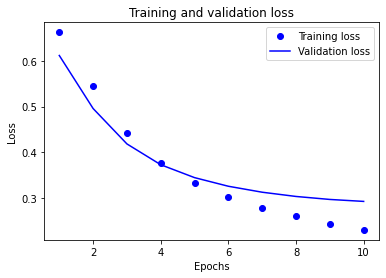

In [53]:
acc = history_dict['binary_accuracy']
val_acc = history_dict['val_binary_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')#x轴，y轴，颜色，标签
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')#x轴标签
plt.ylabel('Loss')#y轴标签
plt.legend()

plt.show()

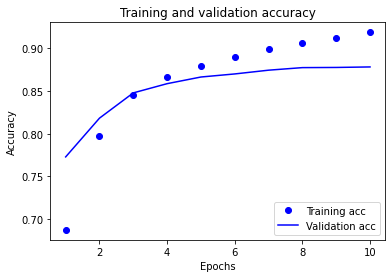

In [54]:
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.show()

导出模型
在上面的代码中，您TextVectorization在将文本输入模型之前将图层应用于数据集。如果您想让您的模型能够处理原始字符串（例如，为了简化部署），您可以TextVectorization在模型中包含该层。为此，您可以使用刚刚训练的权重创建一个新模型。

In [55]:
export_model = tf.keras.Sequential([
  vectorize_layer,#处理层
  model,#训练好的模型
  layers.Activation('sigmoid')
])

export_model.compile(
    loss=losses.BinaryCrossentropy(from_logits=False), optimizer="adam", metrics=['accuracy']
)

# Test it with `raw_test_ds`, which yields raw strings
loss, accuracy = export_model.evaluate(raw_test_ds)
print(accuracy)

782/782 [==============================] - 8s 9ms/step - loss: 0.3115 - accuracy: 0.8737
0.8737199902534485


In [61]:
#预测新的实例
examples = [
  "great great great great great great!",
  "The movie was okay.",
  "The movie was terrible..."
]

export_model.predict(examples)

array([[0.95154035],
       [0.357604  ],
       [0.36342096]], dtype=float32)